In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path,filter ='data')
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
#total_bedrooms attribute only has 20433 non-null values, meaning 207 housing districts are missing this feature

In [10]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


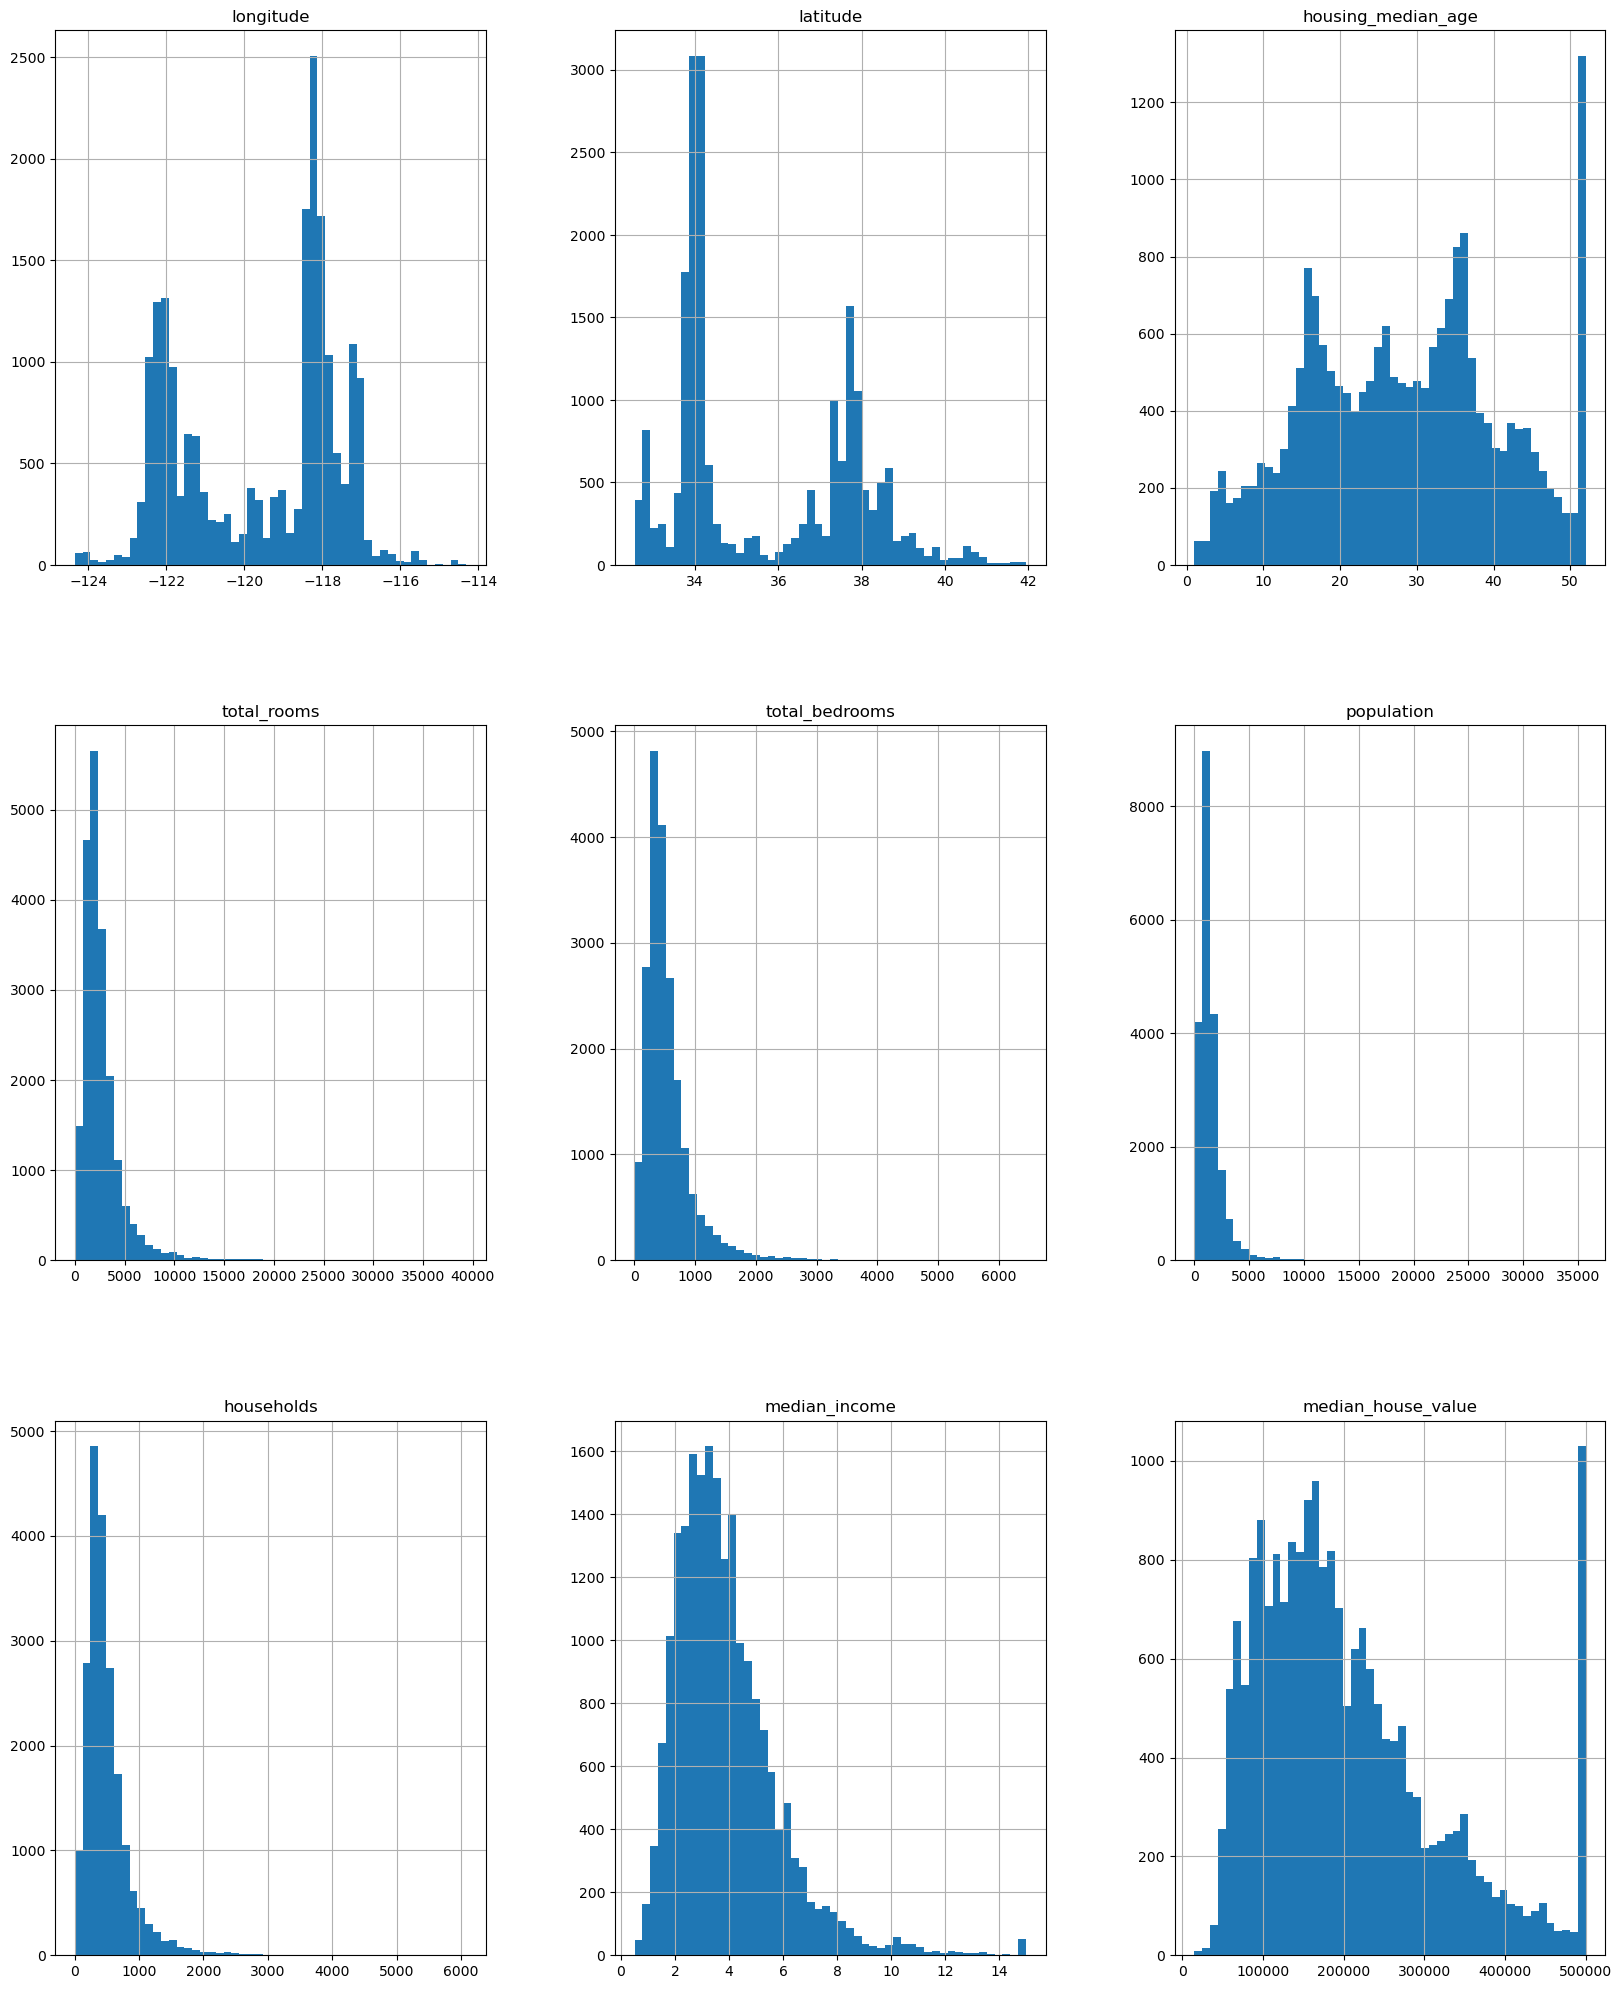

In [12]:
%matplotlib inline
#Only in a jupyter notebook

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,25))
plt.show()
#show() is optional in a jupyter notebook as Jupyter will automatically display plots when a cell is executed.

In [13]:
#create a test set
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data) * test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set, test_set = split_train_test(housing,0.2)
print('Train Set Size',len(train_set))
print('Test Set Size',len(test_set))


Train Set Size 16512
Test Set Size 4128


In [15]:
#this works but it's not perfect because if you run the program again, it will generate different test set! overtime ML algorithm will see all the dataset
#a common solution is to compute a hash of each instance's identifier and put that instance in the test set if the hash is lower or equal to 20% of the new instances, but it will not contain any instance that was previously in the training set

from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids= data[id_column]
    in_test_set= ids. apply (lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]

In [16]:
#unfortunately the housing data does not have an identifier column. the simplest solution is to use the row index as the ID:
housing_with_id= housing.reset_index() #adds an index column
train_set,test_set = split_train_test_by_id(housing_with_id, 0.2,"index")
#if you use the row index as a unique identifier, you need to make sure that new data get appended to the end of the dataset, and no row ever gets deleted

In [17]:
#if that is not possible you can try to use the most stable features to build a unique identifier.
#eg: a district's latitude and longitude as guaranteed to be stable for few million years. so you can combine then into an ID like so:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set,test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [18]:
#scikit-learn provides few functions to split datasets into multiple subsets in various ways
#simplest function is train_test_split, which does pretty much the same thin as the function split_train_test defined earlier, with a couple of additional features.
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
#so far we have considered purely random sampling methods, this is generally fine if dataset is large enough, otherwise there will be sampling bias

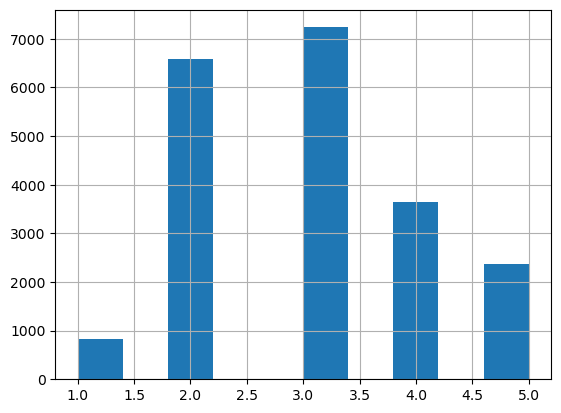

In [19]:
# page 57 book some insights, stratified sampling to solve above issues
housing["income_cat"]=pd.cut(housing["median_income"],
                             bins=[0.,1.5,3.0,4.5,6., np.inf],
                             labels=[1,2,3,4,5])
housing["income_cat"].hist()
plt.show()

In [20]:
#now we are ready to do stratified sampling based on the income category.
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set= housing.loc[test_index]

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [22]:
#now we should remove the income_cat attribute so the data is back to its original state:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis= 1, inplace=True)

In [23]:
#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##Discover and visualize the data to gain insights
housing = strat_train_set.copy()

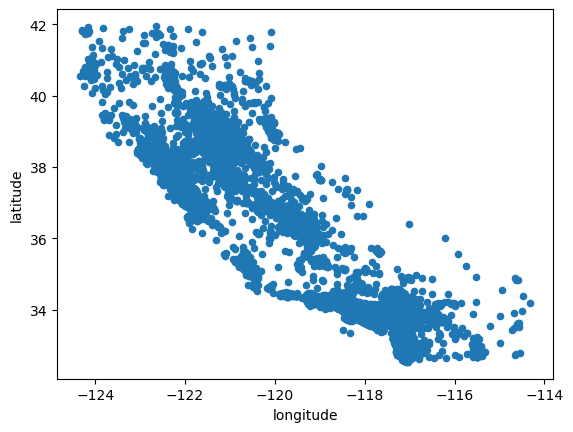

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

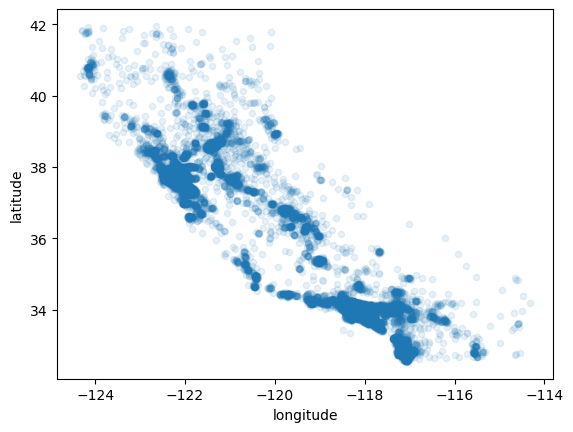

In [25]:
#this does look like california but it is hard to see any particular pattern
#setting the alpha option to 0.1 makes it much easier to visualize the places where there is high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

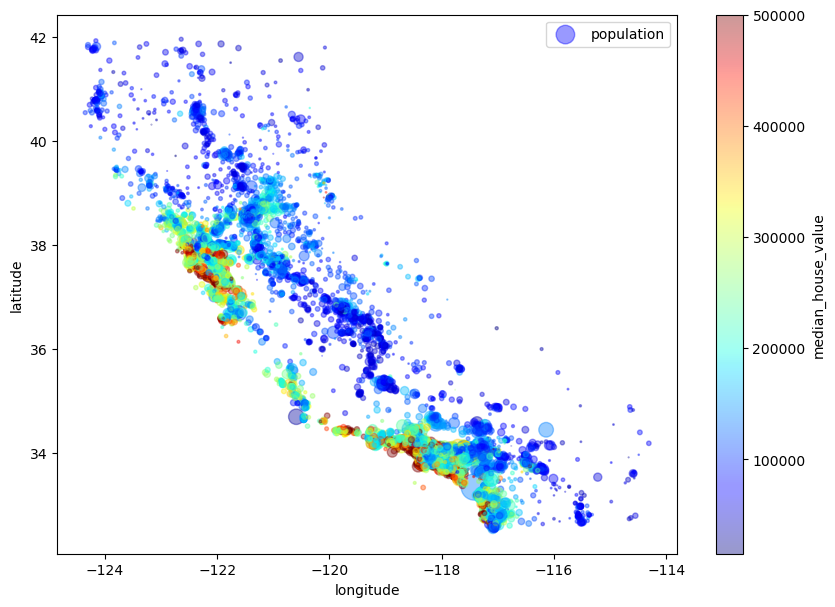

In [27]:
plt.show()

In [28]:
#this image tells that housing prices are very much related to the location, close to ocean means more expensive and to population density
#|||||||||||||||||||||||||||||||
#looking for correlations
corr_matrix = housing.select_dtypes(include=["number"]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [29]:
#correlation ranges from -1 to 1. when it is close to 1, it means that there is a strong positive correlation.
#the median house value tends to go up when the median income goes up
#coefficients close to zero means there is no linear correlation
#close to -1 means there is a strong negative correlation

#correlation coefficient only measures linear correlations(if x goes up then y generally goes up/down)
#It may missout on non linear relationships(if x is close to zero then y generally goes up)


In [30]:
#another way to check for correlation between attributes is to us pandas' scatter_matric function
#it plots every numerical attribute against every other numerical attribute


In [31]:
from pandas.plotting import scatter_matrix
attributes =["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,18))


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

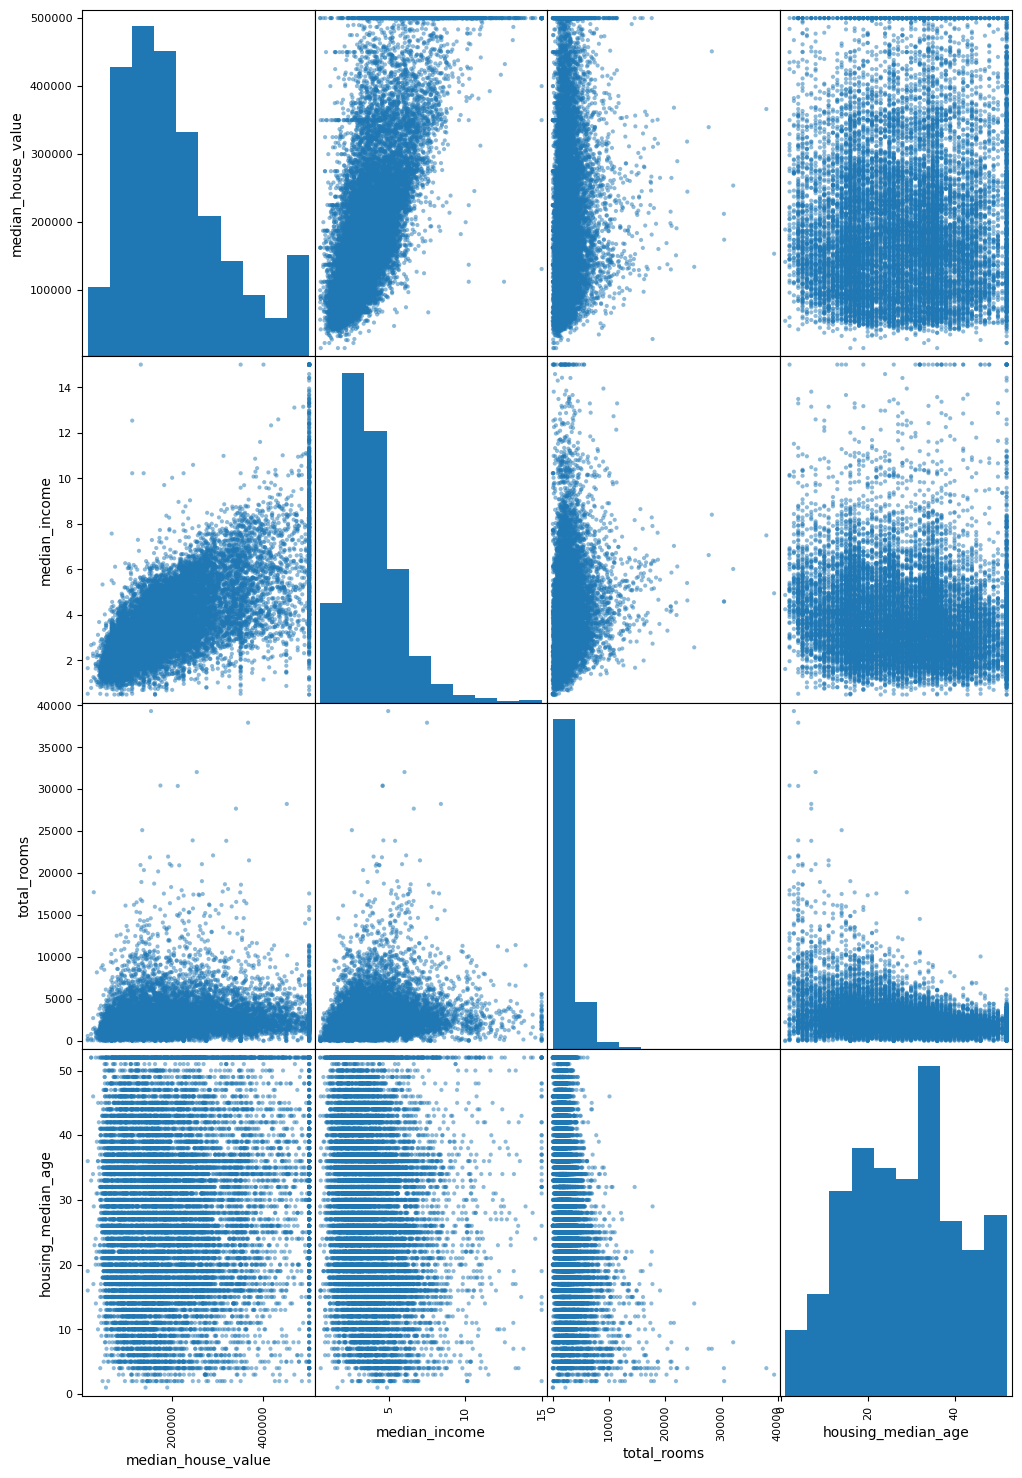

In [32]:
plt.show()

In [33]:
#the most promising attribute to predict the median house value is the median income so lets zoom in on their correlation
housing.plot(kind="scatter", x="median_income", y= "median_house_value", alpha=0.1)

<Axes: xlabel='median_income', ylabel='median_house_value'>

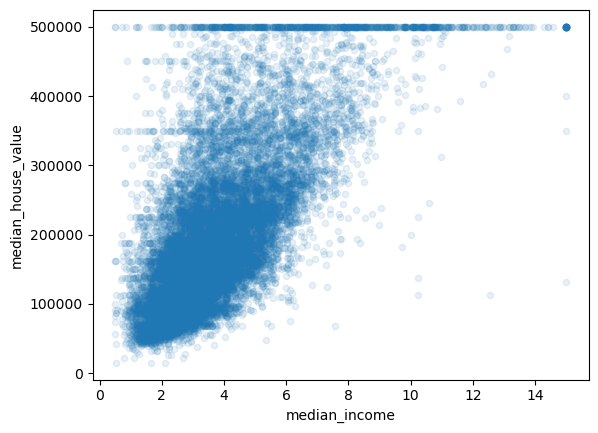

In [34]:
plt.show()

In [35]:
# we see less obvious straight lines around 450000, 350000, and 280000 and some more. we may want to try removing them to prevent algorithms from learning to reproduce them
#experimenting with attribute combinations
# for eg: the total no of rooms in a district is not useful is you don't know how many households there are
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [36]:
corr_matrix=housing.select_dtypes(include=['number']).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [37]:
#prepare the data for machine learning algorithms
#first lets revert to a clean training set(by copying strat_train_set once again)
#lets separate the predictors and the labels since we don't necessarily want to apply the same transformations to the predictors and target values

In [38]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [39]:
#Data Cleaning
#many different options to clean data. see book page 67

In [40]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="median")

In [41]:
#since the median can only be computed on numerical attributes, we need to create a copy of data without the text attribute ocean_proximity:
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [43]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [44]:
#now we can use this 'trained' imputer to tranform the training set by replacing missing values by the learned medians:
X=imputer.transform(housing_num)
#the result is a plain numpy array containing transformed features

In [45]:
# if you want to put it back into a pandas dataframe:
housing_tr =pd.DataFrame(X,columns=housing_num.columns)

In [46]:
#handling text and categorical attributes
# earlier we left out ocean_proximity because it is a text attribute so we can't compute median
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [47]:
# most ML algorithms prefer to work with numbers so convert from text to numbers.
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder= OrdinalEncoder()

In [48]:
housing_cat_encoded= ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [49]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [50]:
# one issue with this representation is that ML algorithm will assume that two nearby values are more similar than two distant values, fine in some cases but not for cases like ocean proximity

In [51]:
# to fix this we use one-hot encoding. see book page 70
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [52]:
#after one hot encoding we get a matrix with thousands of columns and matrix is full of zeroes except for a single 1 per row
# using up tons of memory mostly to store zeros would be very wasteful, so instead a sparce matrix only stores the location of the non-zero elements. YOu can use it mostly like a normal 2D array
#but you can convert it to a (dense) numpy array, just call the toarray() method

In [53]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [55]:
#if a categorical attribute has a large number of possible categories then one hot encoding will result in a large number of input features. this may slow down training and degrade performance
#you could replace the categorical input with useful numerical features related to the categories.
#for eg: you could replace the ocean proximity feature with distance to ocean.
#alternatively you could replace each category with a learnable low dimensional vector called an embedding.

In [56]:
#custom transformers
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        population_per_household= X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room= False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [57]:
#Feature Scaling
# there are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

In [58]:
#transformation pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), ('attrib_adder', CombinedAttributesAdder()),('std_scaler', StandardScaler()),
     ])
housing_num_tr= num_pipeline.fit_transform(housing_num)

In [59]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs= ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [60]:
#select and train a model
#training and evaluating on the training set
#first train a linear regression model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
#done now we have a working linear regression model

LinearRegression()

In [61]:
some_data= housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [62]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [63]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse= mean_squared_error(housing_labels, housing_predictions)
lin_rmse= np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [64]:
# a prediction error of $68628 is not very satisfying. this is an example of model underfitting
#it can mean that the features do not provide enough information to make good predictions or that model is not powerful enough

In [65]:
#train a DecisionTreeRegressor. this is a powerful model capable of finding complex nonlinear relationships in data
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [66]:
# now that the model is trained, lets evaluate it on the training set:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse= mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse
# the result is too perfect with no error becaue the model has badly overfit the data

0.0

In [67]:
# Better evaluation using cross-validation
# use scikit-learn's K-fold cross-validation feature. page 77. read. important
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [68]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_scores(tree_rmse_scores)

Scores:  [73014.77038069 69326.07703236 67360.80308705 70977.30149135
 71857.85885443 77862.02276875 70861.34236291 73979.14438568
 67613.88635405 70211.80302733]
Mean:  71306.50097445918
Standard deviation:  2965.9902950556775


In [69]:
# now it looks even worse than the linear regression model
#notice corss-validation allows you to get not only an estimate of the performance of your model but also a measure of how precise this estimate is(i.e. standard deviation)

In [70]:
# lets compute the same scores for the linear regression model just to be sure
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
# the decision tree model is overfitting so badly that it performs worse than linear regression model

Scores:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean:  69104.07998247063
Standard deviation:  2880.3282098180657


In [71]:
#lets try one last model now: RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
# forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

In [72]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Random Forest RMSE on Training Set:", forest_rmse)

Random Forest RMSE on Training Set: 19113.356374765943


In [73]:
# Cross-validation for Random Forest
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [51721.99130301 49008.35903776 47584.34165752 52439.00505304
 48296.12527467 52661.6774378  53255.2643951  50652.40488623
 49130.23043225 54493.52533444]
Mean:  50924.292481180935
Standard deviation:  2216.9337862606403


In [74]:
# this is much better than other algorithms but still overfitting the training set
# #you can easily save scikit-learn models by using python's pickle module or using sklearn.externals.joblist, which is more efficient at serializing large numpy arrays:


In [75]:
import joblib
joblib.dump(forest_reg,"my_model.pkl")
# and later
my_model_loaded = joblib.load("my_model.pkl")

In [76]:
# fine tune your model
#grid search
# the following code searches for the best combination of hyperparameter values for the randomforestregressor
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2,3,4]},
]
forest_reg= RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [77]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [78]:
# since 6 and 30 are the max values that were evaluated, you should probably try searching again with higher values, since the score may continue to improve

In [79]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [162]:
cvres= grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63842.81733762607 {'max_features': 2, 'n_estimators': 3}
55345.399184892136 {'max_features': 2, 'n_estimators': 10}
53018.52492850759 {'max_features': 2, 'n_estimators': 30}
60455.50352521808 {'max_features': 4, 'n_estimators': 3}
52841.39590480268 {'max_features': 4, 'n_estimators': 10}
50509.66346288572 {'max_features': 4, 'n_estimators': 30}
58980.120847083504 {'max_features': 6, 'n_estimators': 3}
52085.064357487456 {'max_features': 6, 'n_estimators': 10}
49890.31877571295 {'max_features': 6, 'n_estimators': 30}
58849.41965450532 {'max_features': 8, 'n_estimators': 3}
52238.96432824689 {'max_features': 8, 'n_estimators': 10}
50110.47384562053 {'max_features': 8, 'n_estimators': 30}
62914.22112004052 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54213.81929991088 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59118.70799852382 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52430.043473502505 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [164]:
# in this example, we obtained the best solution in 49890.31877571295 {'max_features': 6, 'n_estimators': 30} which is the smallest RMSE score better than previous hyperparameters which was 50924

In [166]:
# Randomized Search is prefered when hyperparameter search space is large


In [168]:
# Ensemble Methods
# another way to fine tune your model is to try to combine the models that perform best.


In [172]:
# Analyze the best models and their errors
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.49977371e-02, 6.74812942e-02, 4.28028925e-02, 1.76373505e-02,
       1.71434847e-02, 1.83908300e-02, 1.70304587e-02, 3.47964766e-01,
       5.69241488e-02, 1.12229513e-01, 6.95126120e-02, 1.29399528e-02,
       1.35921943e-01, 9.07726306e-05, 2.28186993e-03, 6.65037372e-03])

In [178]:
# lets display these importanece scores next to their corresponding attribute names:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34796476624567024, 'median_income'),
 (0.1359219434631075, 'INLAND'),
 (0.11222951280833435, 'pop_per_hhold'),
 (0.07499773707174741, 'longitude'),
 (0.06951261195346972, 'bedrooms_per_room'),
 (0.0674812942310938, 'latitude'),
 (0.056924148797874, 'rooms_per_hhold'),
 (0.04280289249488565, 'housing_median_age'),
 (0.01839082995625065, 'population'),
 (0.01763735047233823, 'total_rooms'),
 (0.017143484737939772, 'total_bedrooms'),
 (0.017030458723773543, 'households'),
 (0.012939952757283145, '<1H OCEAN'),
 (0.0066503737207747405, 'NEAR OCEAN'),
 (0.0022818699348216317, 'NEAR BAY'),
 (9.077263063564126e-05, 'ISLAND')]

In [180]:
# with this info you may want to try dropping some of the less useful features

In [184]:
# Evaluate your system on the test set
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [186]:
final_rmse

48116.71534643164

In [188]:
# see book page83 for understanding
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1, loc= squared_errors.mean(), scale = stats.sem(squared_errors)))

array([46141.2000744 , 50014.26043793])

In [190]:
# the performance will usually be sligtly worse than what you measured using cross-validation if you did a lot of hyperparameter tuning. When this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set

In [192]:
# you could compute the interval manually like this:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(46141.200074400804, 50014.26043793086)

In [194]:
# Alternatively, we could use a z-scores rather than t-scores:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)


(46141.79184878732, 50013.714483551856)